# Simple Neural Network

Building small neural network using Tensorflow, and using Numpy

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.activations import sigmoid
plt.style.use('../helpers/custom.mplstyle')

## Dataset

In [22]:
def load_coffee_data():
    """ Creates a coffee roasting data set.
        roasting duration: 12-15 minutes is best
        temperature range: 175-260C is best
    """
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1,2)
    X[:,1] = X[:,1] * 4 + 11.5          # 12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(X))
    
    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1,1))

In [23]:
X,Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


Let's plot the coffee roasting data below. The two features are Temperature in Celsius and Duration in minutes. [Coffee Roasting at Home](https://www.merchantsofgreencoffee.com/how-to-roast-green-coffee-in-your-oven/) suggests that the duration is best kept between 12 and 15 minutes while the temp should be between 175 and 260 degrees Celsius. Of course, as temperature rises, the duration should shrink. 

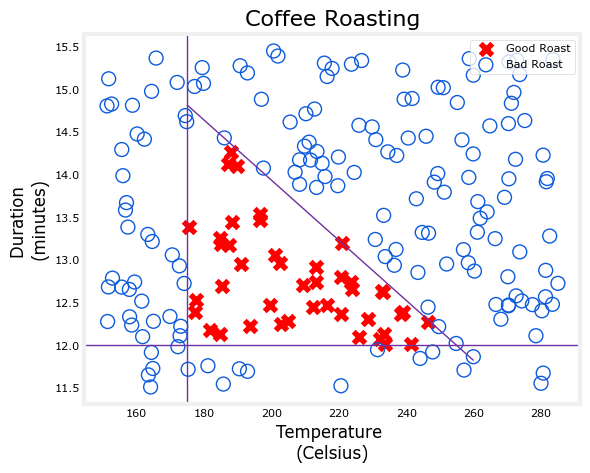

In [24]:
Y_tmp = Y.reshape(-1,)
colormap = np.array(['r', 'b'])
fig, ax = plt.subplots(1,1,)
ax.scatter(X[Y_tmp==1,0],X[Y_tmp==1,1], s=70, marker='x', c='red', label="Good Roast" )
ax.scatter(X[Y_tmp==0,0],X[Y_tmp==0,1], s=100, marker='o', facecolors='none', 
            edgecolors='#0D5BDC',linewidth=1,  label="Bad Roast")
tr = np.linspace(175,260,50)
ax.plot(tr, (-3/85) * tr + 21, color='#7030A0',linewidth=1)
ax.axhline(y=12,color='#7030A0',linewidth=1)
ax.axvline(x=175,color='#7030A0',linewidth=1)
ax.set_title(f"Coffee Roasting", size=16)
ax.set_xlabel("Temperature \n(Celsius)",size=12)
ax.set_ylabel("Duration \n(minutes)",size=12)
ax.legend(loc='upper right')
plt.show()

### Normalize Data
Fitting the weights to the data will proceed more quickly if the data is normalized. Features in the data are each normalized to have a similar range. 
The procedure below uses a Keras [normalization layer](https://keras.io/api/layers/preprocessing_layers/numerical/normalization/). It has the following steps:
- create a "Normalization Layer". Note, as applied here, this is not a layer in your model.
- 'adapt' the data. This learns the mean and variance of the data set and saves the values internally.
- normalize the data.  
It is important to apply normalization to any future data that utilizes the learned model.

In [25]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")

norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)  # learns mean, variance
Xn = norm_l(X)

print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


Tile/copy our data to increase the training set size and reduce the number of training epochs.

In [26]:
Xt = np.tile(Xn,(1000,1))
Yt= np.tile(Y,(1000,1))   
print(Xt.shape, Yt.shape) 

(200000, 2) (200000, 1)


## Tensorflow Model

In [27]:
tf.random.set_seed(1234)  # applied to achieve consistent results
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
    ]
)

>**Note 1:** The `tf.keras.Input(shape=(2,)),` specifies the expected shape of the input. This allows Tensorflow to size the weights and bias parameters at this point.  This is useful when exploring Tensorflow models. This statement can be omitted in practice and Tensorflow will size the network parameters when the input data is specified in the `model.fit` statement.  
>**Note 2:** Including the sigmoid activation in the final layer is not considered best practice. It would instead be accounted for in the loss which improves numerical stability. This will be described in more detail in a later lab.

The `model.summary()` provides a description of the network:

In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.

In [29]:
L1_num_params = 2 * 3 + 3   # W1 parameters  + b1 parameters
L2_num_params = 3 * 1 + 1   # W2 parameters  + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params  )

L1 params =  9 , L2 params =  4


Let's examine the weights and biases Tensorflow has instantiated.  The weights $W$ should be of size (number of features in input, number of units in the layer) while the bias $b$ size should match the number of units in the layer:
- In the first layer with 3 units, we expect W to have a size of (2,3) and $b$ should have 3 elements.
- In the second layer with 1 unit, we expect W to have a size of (3,1) and $b$ should have 1 element.

In [30]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[ 0.81667113  0.904377   -0.8503178 ]
 [ 0.9630852  -0.60814476 -0.7267214 ]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[-0.9596781 ]
 [-0.26586252]
 [ 0.87577593]] 
b2(1,): [0.]


- The `model.compile` statement defines a loss function and specifies a compile optimization.
- The `model.fit` statement runs gradient descent and fits the weights to the data.

In [31]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt,Yt,            
    epochs=10,
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 964us/step - loss: 0.2564
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 939us/step - loss: 0.1335
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 932us/step - loss: 0.1209
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 955us/step - loss: 0.0896
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 846us/step - loss: 0.0213
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 904us/step - loss: 0.0130
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 950us/step - loss: 0.0090
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0064  
Epoch 9/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 996us/step - loss: 0.0046
Epoch 10/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0033


#### Epochs and batches
In the `fit` statement above, the number of `epochs` was set to 10. This specifies that the entire data set should be applied during training 10 times.  During training, you see output describing the progress of training that looks like this:
```
Epoch 1/10
6250/6250 [==============================] - 6s 910us/step - loss: 0.1782
```
The first line, `Epoch 1/10`, describes which epoch the model is currently running. For efficiency, the training data set is broken into 'batches'. The default size of a batch in Tensorflow is 32. There are 200000 examples in our expanded data set or 6250 batches. The notation on the 2nd line `6250/6250 [====` is describing which batch has been executed.

#### Updated Weights
After fitting, the weights have been updated: 

In [32]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[-1.0098347e-02 -1.0569051e+01 -1.7327085e+01]
 [-8.5123644e+00 -1.8141381e-01 -1.4556793e+01]] 
b1: [-10.645871 -11.575933  -2.570186]
W2:
 [[-41.68636 ]
 [-46.044163]
 [ 32.839043]] 
b2: [-9.015752]


### Predictions
Once you have a trained model, you can then use it to make predictions. Recall that the output of our model is a probability. In this case, the probability of a good roast. To make a decision, one must apply the probability to a threshold. In this case, we will use 0.5

In [ ]:
X_test = np.array([
    [200, 13.9],  # positive example
    [200, 17]])   # negative example

X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
predictions = 
 [[9.566584e-01]
 [1.174153e-04]]


In [34]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


This can be accomplished more succinctly:

In [35]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


## Layer Functions
Let's examine the functions of the units to determine their role in the coffee roasting decision. We will plot the output of each node for all values of the inputs (duration,temp). Each unit is a logistic function whose output can range from zero to one. The shading in the graph represents the output value.

In [36]:
import matplotlib.colors as colors
from matplotlib import cm

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """ truncates color map """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def plt_prob(ax,fwb):
    """ plots a decision boundary but include shading to indicate the probability """
    #setup useful ranges and common linspaces
    x0_space  = np.linspace(150, 285 , 40)
    x1_space  = np.linspace(11.5, 15.5 , 40)

    # get probability for x0,x1 ranges
    tmp_x0,tmp_x1 = np.meshgrid(x0_space,x1_space)
    z = np.zeros_like(tmp_x0)
    for i in range(tmp_x0.shape[0]):
        for j in range(tmp_x1.shape[1]):
            x = np.array([[tmp_x0[i,j],tmp_x1[i,j]]])
            z[i,j] = fwb(x)


    cmap = plt.get_cmap('Blues')
    new_cmap = truncate_colormap(cmap, 0.0, 0.5)
    pcm = ax.pcolormesh(tmp_x0, tmp_x1, z,
                   norm=cm.colors.Normalize(vmin=0, vmax=1),
                   cmap=new_cmap, shading='nearest', alpha = 0.9)
    ax.figure.colorbar(pcm, ax=ax)

def plt_layer(X,Y,W1,b1,norm_l):
    Y = Y.reshape(-1,)
    fig,ax = plt.subplots(1,W1.shape[1], figsize=(16,4))
    for i in range(W1.shape[1]):
        layerf= lambda x : sigmoid(np.dot(norm_l(x),W1[:,i]) + b1[i])
        plt_prob(ax[i], layerf)
        ax[i].scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
        ax[i].scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', facecolors='none', 
                   edgecolors='#0D5BDC',linewidth=1,  label="Bad Roast")
        tr = np.linspace(175,260,50)
        ax[i].plot(tr, (-3/85) * tr + 21, color='#7030A0',linewidth=2)
        ax[i].axhline(y= 12, color='#7030A0', linewidth=2)
        ax[i].axvline(x=175, color='#7030A0', linewidth=2)
        ax[i].set_title(f"Layer 1, unit {i}")
        ax[i].set_xlabel("Temperature \n(Celsius)",size=12)
    ax[0].set_ylabel("Duration \n(minutes)",size=12)
    plt.show()

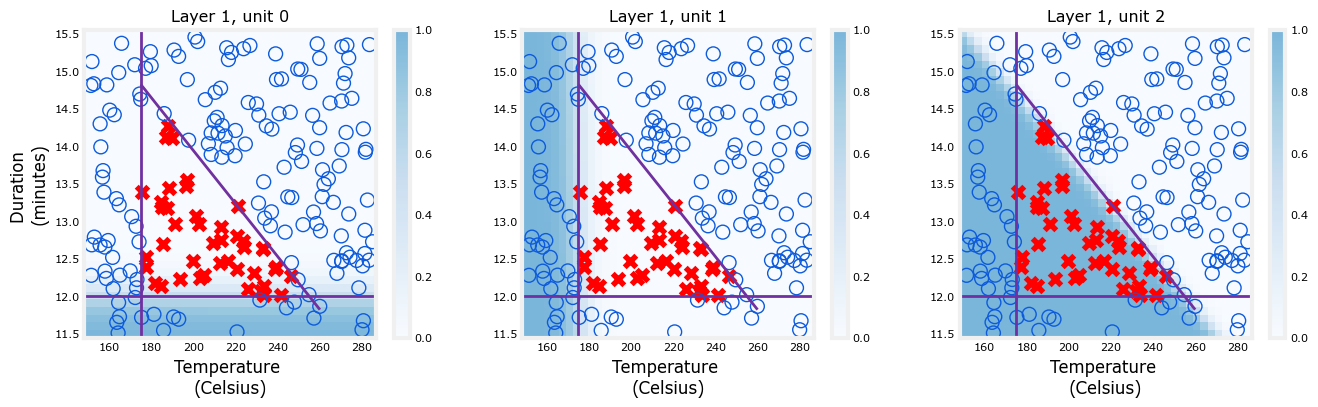

In [37]:
plt_layer(X, Y.reshape(-1,), W1, b1, norm_l)

## Numpy Model (Forward Prop in NumPy)

Let's build the "Coffee Roasting Network". There are two layers with sigmoid activations.

In [39]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Parameters
    ----------
    z : array_like
        A scalar or numpy array of any size.

    Returns
    -------
     g : array_like
         sigmoid(z)
    """
    z = np.clip( z, -500, 500 )           # protect against overflow
    g = 1.0/(1.0+np.exp(-z))

    return g

# Define the activation function
g = sigmoid

Next, lets define the `my_dense()` function which computes the activations of a dense layer.

In [40]:
def my_dense(a_in, W, b):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data, 1 example 
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units  
    Returns
      a_out (ndarray (j,))  : j units|
    """
    units = W.shape[1]
    a_out = np.zeros(units)
    for j in range(units):               
        w = W[:,j]                                    
        z = np.dot(w, a_in) + b[j]         
        a_out[j] = g(z)               
    return(a_out)

The following cell builds a two-layer neural network utilizing the `my_dense` subroutine above.

In [41]:
def my_sequential(x, W1, b1, W2, b2):
    a1 = my_dense(x,  W1, b1)
    a2 = my_dense(a1, W2, b2)
    return(a2)

We can copy trained weights and biases from the above implementation using Tensorflow.

In [42]:
W1_tmp = np.array( [[-8.93,  0.29, 12.9 ], [-0.1,  -7.32, 10.81]] )
b1_tmp = np.array( [-9.82, -9.28,  0.96] )
W2_tmp = np.array( [[-31.18], [-27.59], [-32.56]] )
b2_tmp = np.array( [15.41] )

### Predictions

Let's start by writing a routine similar to Tensorflow's `model.predict()`. This will take a matrix $X$ with all $m$ examples in the rows and make a prediction by running the model.

In [50]:
def my_predict(X, W1, b1, W2, b2):
    m = X.shape[0]
    p = np.zeros((m,1))
    for i in range(m):
        p[i,0] = my_sequential(X[i], W1, b1, W2, b2).item()
    return(p)

In [51]:
X_tst = np.array([
    [200, 13.9],  # postive example
    [200, 17]])   # negative example
    # Ensure input to my_predict is a numpy array, and output is squeezed to avoid DeprecationWarning

X_tstn = norm_l(X_tst)  # remember to normalize
predictions = my_predict(X_tstn, W1_tmp, b1_tmp, W2_tmp, b2_tmp)

In [52]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]
